## Nutrient Demands



### Introduction



In our last project we used data to estimate systems of food demand
using different datasets.  An output from that project was as set of
`cfe.Regression` objects; these bundle together both data and the results
from the demand system estimation, and can be used for prediction as
well.

Here we&rsquo;ll explore some of the uses of the `cfe.Regression` class, using
an instance created previously (as in Project 3).

After having estimated a demand system using data from our favorite country, we can imagine different counterfactual scenarios.  What if prices were different?  What if we give a cash transfer to a household?  What if school fees reduce the budget for food?  What are the consequences of any of these for diet & nutrition?

If you don&rsquo;t already have the latest version of the `CFEDemands` package
installed, grab it, along with some dependencies:



In [1]:
!pip install -r requirements.txt

In [36]:
import pandas as pd
import cfe.regression as rgsn

### Data



We&rsquo;ll get data from two places.  First, basic data, including a food
 conversion table and recommended daily intakes table can be found in
 a google spreadsheet.

Here are addresses of google sheets for different dataframes for the
case of Uganda:



In [37]:
InputFiles = {'Expenditures':('1POplhyd44h-Zt8jMhXa2FGAzS051TPoLa2xMlmvVLU0','Expenditures'),
              'Prices':('1XaJJuVpHAJ2kK-wOg7CfdENc6XISYY_NKL0lK9wGEcU','Food Prices'),
              'HH Characteristics':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','HH Characteristics'),
              'FCT':('18EuF3OLGDB6-hb9PToJzDMfyvN8cDqEpzPmQl9leJBU','For Use in Code'),
              'RDI':('1y95IsQ4HKspPW3HHDtH7QMtlDA66IUsCHJLutVL-MMc','diet_minimums'),}

#### Prices, FCT, RDI



In [38]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    return get_clean_df(df)

def get_clean_df(df):
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]
    
    return df
    

# Get prices
#p = get_clean_sheet(InputFiles['Prices'][0],sheet=InputFiles['Prices'][1])

p = read_sheets(InputFiles['Prices'][0],sheet=InputFiles['Prices'][1])
p = p.rename({'': 'units'},axis=1) #Rename units column
p = p.loc[p['units']!='piece'] #Only use kg units..
p = pd.DataFrame(np.vstack([p.columns, p])) # Make t column header as a row
p = p.drop(1, axis=1) # Drop units column
p = p.T #Transpose p
p.columns = p.iloc[0] #Make first row into column header
p = p.drop(0, axis=0) #Drop first row (current column header)
p = p.reset_index(drop=True)

p = get_clean_df(p)

p = p.drop('j',axis=1)

if 'm' not in p.columns:  # Supply "market" indicator if missing
    p['m'] = 1

p = p.set_index(['t','m'])
p.columns.name = 'j'

p = p.apply(lambda x: pd.to_numeric(x,errors='coerce'))
p = p.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

fct = fct.rename(columns={"Item name": "j"})

fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

################## RDI, if available (consider using US) ##################### ## CHECK: Are we using US or Tanzania?
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])

rdi = rdi.rename(columns={"Nutrition": "n"})
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


#### Pre-estimated Demand Systems



An instance `r` of `cfe.Regression` can be made persistent with
 `r.to_pickle('my_result.pickle')`, which saves the instance &ldquo;on disk&rdquo;, and can be loaded using `cfe.regression.read_pickle`.  We use  this method below to load data and demand system previously estimated for Uganda:



In [39]:
r = rgsn.read_pickle('Tanzania_results.pickle')  # Assumes you've already set this up e.g., in Project 3

#### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [40]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.xs('2010-11',level='t').mean()

pbar = pbar[r.beta.index] # Only use prices for goods we can estimate

In [41]:
pbar.shape

(38,)

#### Budgets



Get food budget for all households, then find median budget:



In [42]:
import numpy as np

xhat = r.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

#### Food Quantities



Get quantities of food by dividing expenditures by prices:



In [43]:
qhat = (xhat.unstack('j')/pbar).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

qhat

j                                 Beef     Bread  Cassava fresh   Chicken   
i     t       m                                                             
1     2012-13 Mainland Rural  0.555117  0.818410       3.563872  0.706799  \
      2014-15 Mainland Rural  1.003237  1.151854       3.704444  1.444235   
2     2014-15 Mainland Rural  0.808600  0.947611       2.895680  1.245344   
4     2012-13 Mainland Rural  0.177281  0.288673       1.367066  0.217727   
      2014-15 Mainland Rural  0.760627  0.955789       2.593857  1.227097   
...                                ...       ...            ...       ...   
14974 2014-15 Mainland Rural  0.743405  0.946368       3.035711  1.189340   
14979 2014-15 Mainland Rural  2.152228  2.622942       5.623407  2.910675   
14980 2014-15 Mainland Rural  1.145856  1.463922       3.248821  1.635055   
14981 2014-15 Mainland Rural  1.470890  2.242089       5.277094  2.455794   
14983 2014-15 Mainland Rural  1.213343  1.381356       3.960147  1.785542   

j                             Citrus fruits  Coconuts  Cooking oil     Dairy   
i     t       m                                                                
1     2012-13 Mainland Rural       0.554148  1.188973     0.372619  0.482494  \
      2014-15 Mainland Rural       1.000775  1.879495     0.583514  1.361778   
2     2014-15 Mainland Rural       0.976377  1.625441     0.546331  1.235574   
4     2012-13 Mainland Rural       0.145835  0.555890     0.134649  0.196704   
      2014-15 Mainland Rural       0.774950  1.640022     0.485135  1.295193   
...                                     ...       ...          ...       ...   
14974 2014-15 Mainland Rural       0.737634  1.496276     0.477704  0.814780   
14979 2014-15 Mainland Rural       2.553872  3.366004     1.503995  2.525840   
14980 2014-15 Mainland Rural       1.292693  2.088786     0.824930  1.239259   
14981 2014-15 Mainland Rural       2.451553  2.838477     1.033834  1.461780   
14983 2014-15 Mainland Rural       1.345643  2.091805     0.732603  1.968615   

j                             Dried/salted/canned fish      Eggs  ...   
i     t       m                                                   ...   
1     2012-13 Mainland Rural                  0.381735  0.172022  ...  \
      2014-15 Mainland Rural                  0.612837  0.326735  ...   
2     2014-15 Mainland Rural                  0.610202  0.336331  ...   
4     2012-13 Mainland Rural                  0.143495  0.058577  ...   
      2014-15 Mainland Rural                  0.538644  0.273027  ...   
...                                                ...       ...  ...   
14974 2014-15 Mainland Rural                  0.539644  0.234601  ...   
14979 2014-15 Mainland Rural                  1.687337  0.573860  ...   
14980 2014-15 Mainland Rural                  0.866240  0.381491  ...   
14981 2014-15 Mainland Rural                  1.213389  0.732603  ...   
14983 2014-15 Mainland Rural                  0.877300  0.390555  ...   

j                             Plantains  Rice (husked)  Ripe bananas   
i     t       m                                                        
1     2012-13 Mainland Rural   1.922827       2.411936      0.464584  \
      2014-15 Mainland Rural   2.453232       3.082451      0.929370   
2     2014-15 Mainland Rural   2.286531       2.741245      0.797484   
4     2012-13 Mainland Rural   0.782086       1.122933      0.119199   
      2014-15 Mainland Rural   2.312928       2.966149      0.753881   
...                                 ...            ...           ...   
14974 2014-15 Mainland Rural   2.065338       2.835221      0.707010   
14979 2014-15 Mainland Rural   5.709123       7.944908      2.584627   
14980 2014-15 Mainland Rural   3.197843       4.776794      1.126506   
14981 2014-15 Mainland Rural   4.432154       6.958037      2.269413   
14983 2014-15 Mainland Rural   3.219885       3.945036      1.072731   

j                                 Salt  Soft drinks   
i     t       m

Finally, define a function to change a single price in the vector $p$:



In [44]:
def my_prices(p0,p=pbar,j='Beef'):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

### Demands



#### Demand functions



In [45]:
pbar.shape

(38,)

In [46]:
p.columns.unique().size

60

/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Set

<IPython.core.display.Javascript object>


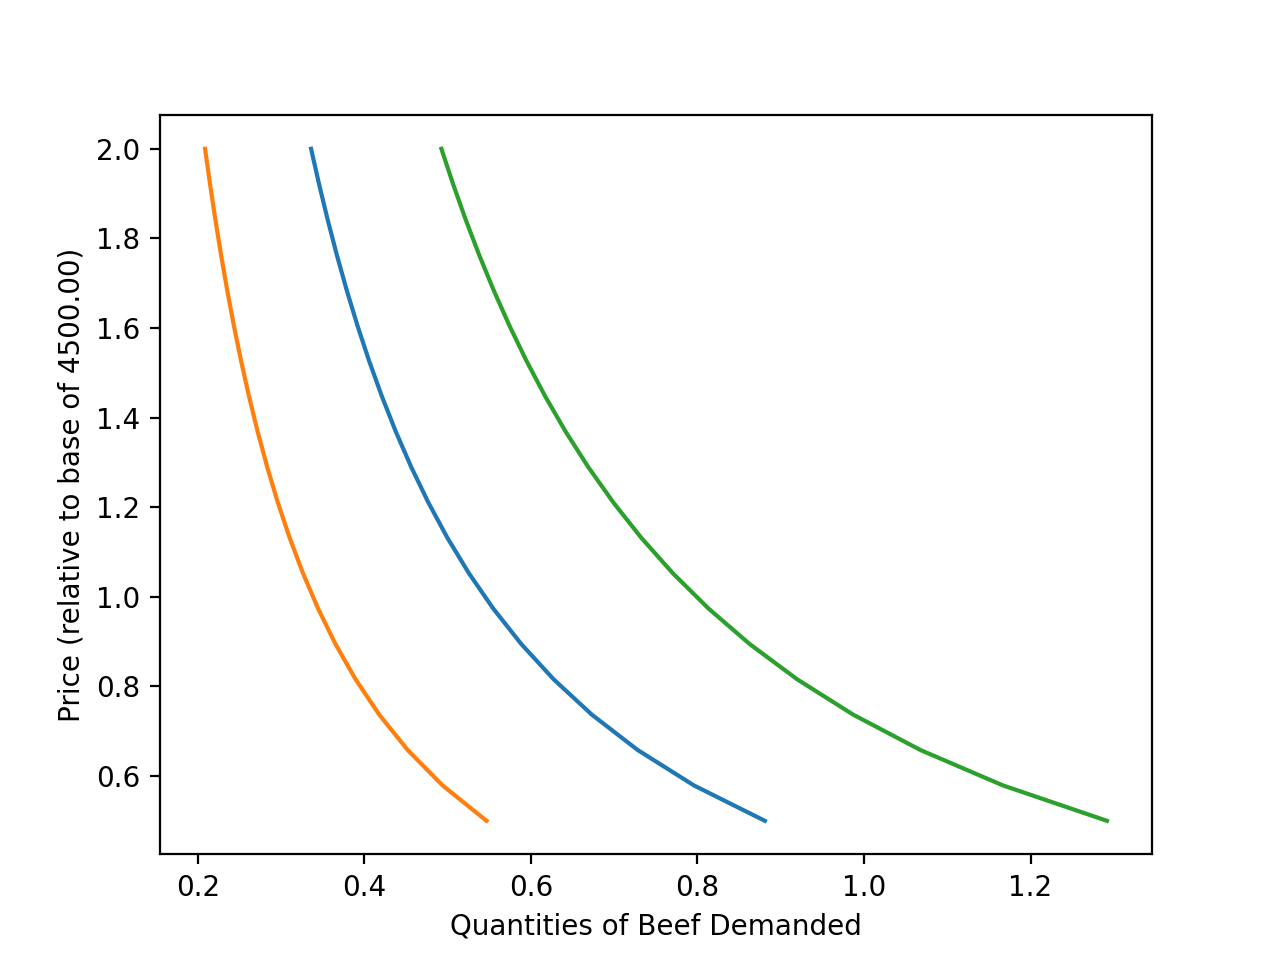

/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Set

Text(0.5, 0, 'Quantities of Beef Demanded')

In [47]:
import matplotlib.pyplot as plt
%matplotlib notebook

use = 'Beef'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([r.demands(xref,my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([r.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([r.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

#### Engel Curves



<IPython.core.display.Javascript object>


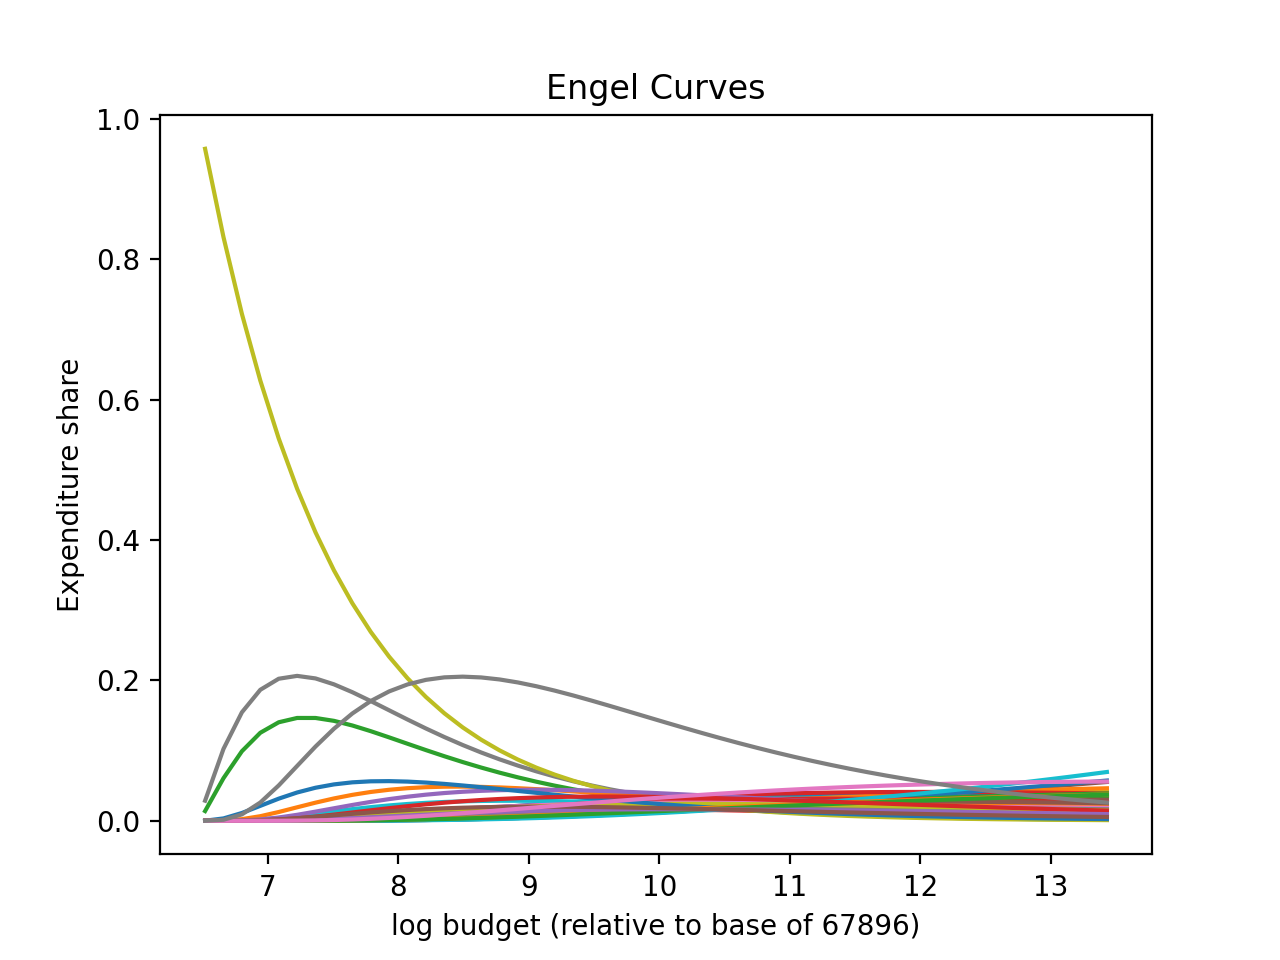

/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Set

/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')
/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')


Text(0.5, 1.0, 'Engel Curves')

In [48]:
fig,ax = plt.subplots()

scale = np.geomspace(.01,10,50)

ax.plot(np.log(scale*xref),[r.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

### Mapping to Nutrients



We&rsquo;ve seen how to map prices and budgets into vectors of consumption
 quantities using `cfe.Regression.demands`.  Next we want to think about
 how to map these into bundles of *nutrients*.  The information needed
 for the mapping comes from a &ldquo;Food Conversion Table&rdquo; (or database,
 such as the [USDA Food Data Central](https://fdc.nal.usda.gov/)).    We&rsquo;ve already grabbed an FCT, let&rsquo;s take a look:



In [49]:
fct

n,Value,energy kcal,protein g,vit a ug,vit d ug,vit e ug,vit c mg,vit b6 mg,vit b12 ug,ca mg,mg mg,fe mg,zn mg
j,,,,,,,,,,,,,
Rice (Paddy),101,358.0,6.5,0.0,0.0,0.0,0.0,0.1,0.0,8.0,36.0,0.6,1.1
Rice (Husked) (white grain raw),102,358.0,6.5,0.0,0.0,0.0,0.0,0.1,0.0,8.0,36.0,0.6,1.1
"Maize (Green, Cob, immature)",103,59.0,1.8,7.0,0.0,0.0,3.0,0.0,0.0,1.0,18.0,0.3,0.3
"Maize (Grain, dry, raw)",104,362.0,8.1,0.0,0.0,1.0,0.0,0.3,0.0,6.0,127.0,3.5,1.8
"Maize (Flour, dry)",105,362.0,8.1,0.0,0.0,1.0,0.0,0.3,0.0,6.0,127.0,3.5,1.8
Millet and Sorghum (Grain),106,328.0,6.6,5.0,0.0,0.0,0.0,0.2,0.0,275.0,27.0,2.7,1.2
Millet and Sorghum (Flour),107,328.0,6.6,5.0,0.0,0.0,0.0,0.2,0.0,275.0,27.0,2.7,1.2
"Bread, white",109,274.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,27.0,0.5,0.9
Cake,110,320.0,4.7,34.0,0.0,1.0,0.0,0.0,0.2,38.0,9.0,0.4,0.4


We need the index of the Food Conversion Table (FCT) to match up with
 the index of the vector of quantities demanded.   To manage this we
 make use of the `align` method for `pd.DataFrames`:



In [50]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(qhat.T,axis=0,join='inner')
print(fct0.index)

Index(['Sugar', 'Eggs', 'Fresh milk', 'Salt', 'Other spices'], dtype='object', name='j')


Now, since rows of `fct0` and `c0` match, we can obtain nutritional
 outcomes from the inner (or dot, or matrix) product of the transposed
 `fct0` and `c0`:



In [51]:
# The @ operator means matrix multiply
N = fct0.T@c0

N  #NB: Uganda quantities are for previous 7 days

i                    1                             2              4       
t                  2012-13        2014-15        2014-15        2012-13   
m           Mainland Rural Mainland Rural Mainland Rural Mainland Rural   
n                                                                         
Value          1692.984604    2715.662135     2685.38851     747.249383  \
energy kcal            NaN            NaN            NaN            NaN   
protein g              NaN            NaN            NaN            NaN   
vit a ug               NaN            NaN            NaN            NaN   
vit d ug               NaN            NaN            NaN            NaN   
vit e ug               NaN            NaN            NaN            NaN   
vit c mg               NaN            NaN            NaN            NaN   
vit b6 mg              NaN            NaN            NaN            NaN   
vit b12 ug             NaN            NaN            NaN            NaN   
ca mg                  NaN            NaN            NaN            NaN   
mg mg                  NaN            NaN            NaN            NaN   
fe mg                  NaN            NaN            NaN            NaN   
zn mg                  NaN            NaN            NaN            NaN   

i                                   5                             8       
t                  2014-15        2012-13        2014-15        2012-13   
m           Mainland Rural Mainland Rural Mainland Rural Mainland Rural   
n                                                                         
Value          2400.423278    5217.378892     6090.80079     2666.42628  \
energy kcal            NaN            NaN            NaN            NaN   
protein g              NaN            NaN            NaN            NaN   
vit a ug               NaN            NaN            NaN            NaN   
vit d ug               NaN            NaN            NaN            NaN   
vit e ug               NaN            NaN            NaN            NaN   
vit c mg               NaN            NaN            NaN            NaN   
vit b6 mg              NaN            NaN            NaN            NaN   
vit b12 ug             NaN            NaN            NaN            NaN   
ca mg                  NaN            NaN            NaN            NaN   
mg mg                  NaN            NaN            NaN            NaN   
fe mg                  NaN            NaN            NaN            NaN   
zn mg                  NaN            NaN            NaN            NaN   

i                                   9      ...                14966   
t                  2014-15        2012-13  ...              2014-15   
m           Mainland Rural Mainland Rural  ... Mainland Other Urban   
n                                          ...                        
Value          3190.025547    1000.092271  ...          4093.195453  \
energy kcal            NaN            NaN  ...                  NaN   
protein g              NaN            NaN  ...                  NaN   
vit a ug               NaN            NaN  ...                  NaN   
vit d ug               NaN            NaN  ...                  NaN   
vit e ug               NaN            NaN  ...                  NaN   
vit c mg               NaN            NaN  ...                  NaN   
vit b6 mg              NaN            NaN  ...                  NaN   
vit b12 ug             NaN            NaN  ...                  NaN   
ca mg                  NaN            NaN  ...                  NaN   
mg mg                  NaN            NaN  ...                  NaN   
fe mg                  NaN            NaN  ...                  NaN   
zn mg                  NaN            NaN  ...                  NaN   

i                          14968          14970          14971          14972   
t                        2014-15        2014-15        2014-15        2014-15   
m           Mainland Other Urban Mainland Rural Mainland Rural Mainland Rural 

Of course, since we can compute the nutritional content of a vector of
 consumption goods `c0`, we can also use our demand functions to
 compute nutrition as a *function* of prices and budget.



In [52]:
def nutrient_demand(x,p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

With this `nutrient_demand` function in hand, we can see how nutrient
 outcomes vary with budget, given prices:



In [53]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(xref/5,xref*5,50)

UseNutrients = ['Protein','Energy','Iron','Calcium','Vitamin C']

#df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
df = pd.DataFrame({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X})
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

/opt/conda/lib/python3.9/site-packages/consumerdemands/_utils.py:52: UserWarning: Setting negative values of beta to zero.
  warnings.warn('Setting negative values of beta to zero.')


KeyError: "None of [Index(['Protein', 'Energy', 'Iron', 'Calcium', 'Vitamin C'], dtype='object', name='n')] are in the [index]"

Now how does nutrition vary with prices?



In [54]:
USE_GOOD = 'Oranges'

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(pbar[USE_GOOD]*s,j=USE_GOOD)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')

KeyError: 'Oranges'

### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For the average household in our data, the number of
different kinds of people can be computed by averaging over households:



In [55]:
# In first round, averaged over households and villages
dbar = r.d.mean().iloc[:-2]

Now, the inner/dot/matrix product between `dbar` and the `rdi`
DataFrame of requirements will give us minimum requirements for the
average household:



In [56]:
# This matrix product gives minimum nutrient requirements for
# the average household
hh_rdi = rdi.replace('',0)@dbar

hh_rdi

ValueError: matrices are not aligned

## Nutritional Adequacy of Food Demands



Since we can trace out demands for nutrients as a function of $(x,p)$,
and we&rsquo;ve computed minimum nutritional requirements for the average
household, we can *normalize* nutritional intake to check the adequacy
of diet for a household with counts of different kinds of people given by `z`.



In [57]:
def nutrient_adequacy_ratio(x,p,d,rdi=rdi,days=7):
    hh_rdi = rdi.replace('',0)@d*days

    return nutrient_demand(x,p)/hh_rdi

In terms of normalized nutrients, any household with more than one
unit of any given nutrient (or zero in logs) will be consuming a
minimally adequate level of the nutrient; below this level there&rsquo;s
clearly nutritional inadequacy.  For this reason the ratio of
actual nutrients to required nutrients is termed the &ldquo;nutrient
adequacy ratio,&rdquo; or NAR.



In [58]:
X = np.geomspace(.01*xref,2*xref,100)

pd.DataFrame({x:np.log(nutrient_adequacy_ratio(x,pbar,dbar))[UseNutrients] for x in X}).T.plot()
plt.legend(UseNutrients)
plt.xlabel('budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(xref)

ValueError: matrices are not aligned

As before, we can also vary relative prices.  Here we trace out
nutritional adequacy varying the price of a single good:



In [59]:
scale = np.geomspace(.01,2,50)

ndf = pd.DataFrame({s*pbar[USE_GOOD]:np.log(nutrient_adequacy_ratio(xref/4,my_prices(pbar[USE_GOOD]*s,j=USE_GOOD),dbar))[UseNutrients] for s in scale}).T

fig,ax = plt.subplots()
ax.plot(ndf['Vitamin C'],ndf.index)
ax.axhline(pbar[USE_GOOD])
ax.axvline(0)

ax.set_ylabel('Price')
ax.set_xlabel('log nutrient adequacy ratio')

KeyError: 'Oranges'